In [1]:
# ------------------------
# ---- import libraries --
# ------------------------
import os,sys
import numpy as np
# xarray
import xarray as xr
# plot
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.ticker as mticker
from matplotlib.colors import Colormap
from matplotlib.colors import from_levels_and_colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cmocean as ccm


vérification qua manometric sea level is equal : from Pb calculation or deduced as the difference between the sla and steric height. 


In [2]:
import multiprocessing.popen_spawn_posix
from distributed import Client
c = Client()
c

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41701 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:44191 Dashboard: http://127.0.0.1:41701/status,Cluster Workers: 5 Cores: 10 Memory: 322.12 GB


# load data

In [3]:
chunk_size = {"x":133,"y":320}
# plot directory
diro = "/gpfsscratch/rech/cli/uor98hu/PLOTS/"

diri="/gpfswork/rech/cli/rcli002/eORCA025.L75/eORCA025.L75-I/"
mesh_hgr = xr.open_dataset(diri+'mesh_hgr.nc',chunks=chunk_size).squeeze()
tmask = mesh_hgr.tmask.isel(nav_lev=0)

In [4]:
# significance threshold
# pval = 0.05
# pval = 0.32
pval = 0.10
alphaHatch = 0.05

In [5]:
# Manometric sea level from computation using bottom pressure

In [26]:
dirmano = "/gpfswork/rech/cli/uor98hu/MYDATA/SLdecomposition_WP1/Mano_from_Pb/"

ds_manTrGAI_PB = xr.open_dataset(dirmano+"eORCA025.L75-IMHOTEP._y2005_2018.1y_trend_mano_GAI_linregress.nc").linregress
# p-value
man_pval_GAI_PB  = ds_manTrGAI_PB.sel(parameter='pvalue')
# slope
man_Tr_GAI_PB = ds_manTrGAI_PB.sel(parameter='slope')

man_TrGAI_PB_signi = tmask.where(man_Tr_GAI_PB > pval)

In [7]:
# man_Tr_GAI_PB.where(nav_lat>65).plot.hist()

In [8]:
# manometric height from the difference of sla and steric height

In [27]:
### SLA

ds_slaGAI = xr.open_dataset('/gpfswork/rech/cli/uor98hu/MYDATA/SSH/GAI/eORCA025.L75-IMHOTEP._y2005_2018.1y_trendGAI_linregress.nc').linregress
# p-value
sla_pval_GAI = ds_slaGAI.sel(parameter='pvalue')
# slope
slaTrGAI = ds_slaGAI.sel(parameter='slope')
sla_TrGAI_signi = tmask.where(sla_pval_GAI>pval)

### STERIC

pathuna12nf= "/gpfswork/rech/cli/uor98hu/MYDATA/SLdecomposition_WP1/una12nf/"
decomp = "steric" 
ds_steGAI = xr.open_dataset(pathuna12nf+'eORCA025.L75-IMHOTEP._y2005_2018.1y_'+decomp+'_0_bottom_trendGAI_linregress.nc').linregress
# # p-value
# ste_pval_GAI = ds_steGAI.sel(parameter='pvalue')
# slope
steTrGAI = ds_steGAI.sel(parameter='slope')

### MANO
manTrGAI_diff  = slaTrGAI  - steTrGAI


In [28]:
# différence absolue
DIFF = abs((man_Tr_GAI_PB - manTrGAI_diff))

In [29]:
DIFF.max().values

array(0.64733392)

# Prepare plot

In [30]:
def vectorize(cs):
    """
    Vectorize contourf plots to reduce weight of figures saved as PDFs.
    """
    for c in cs.collections:
        c.set_rasterized(True)

In [31]:
# read grid files
diri="/gpfswork/rech/cli/rcli002/eORCA025.L75/eORCA025.L75-I/"
nav_lon = mesh_hgr.nav_lon
nav_lat = mesh_hgr.nav_lat

mbathy = xr.open_dataset(diri+'eORCA025.L75_domain_cfg_closed_seas_greenland.nc')['bathy_meter'].isel(t=0) # grille lat/lon

BGRmask = xr.open_dataset('/gpfswork/rech/cli/uor98hu/MYDATA/TRANSPORT_WP1/BGRmaskobs.nc').BGRmask.squeeze()
# default gridlines parameters
gridl=False
incrgridlon=30
incrgridlat=10

# vue N.Atl
# loncentr=330 # before it was zero
# latcentr=70

#vue polaire
loncentr=200 # before it was zero
latcentr=90

sath=2085831


In [32]:
#========= Plot settings ===============
# colormap
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [33]:
cmap1 = cm.RdYlBu_r
my_map1 = truncate_colormap(cmap1)
colors1 = my_map1(np.linspace(0., 1, 50))
mycm1 = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors1)

lmin = -10.0
incr = 1
lmax = lmin*(-1)+0.1
# define the bins and normalize
bounds1 = np.arange(lmin,lmax,incr)

norm1 = mcolors.BoundaryNorm(bounds1, mycm1.N)

In [54]:
bounds1

array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.])

In [34]:
y1='2005'
y2='2018'

In [49]:
# carte des erreurs relatives

cmap2 = cm.Reds
my_map2 = truncate_colormap(cmap2)
colors2 = my_map2(np.linspace(0., 1, 50))
mycm2 = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors2)

# lmin = -1.0
# incr = 0.1
# lmax = lmin*(-1)+0.1
# define the bins and normalize
bounds2 = np.arange(0,.35,0.05)

norm2 = mcolors.BoundaryNorm(bounds2, mycm2.N)

In [50]:
bounds2

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 ])

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/gpfslocalsup/pub/anac

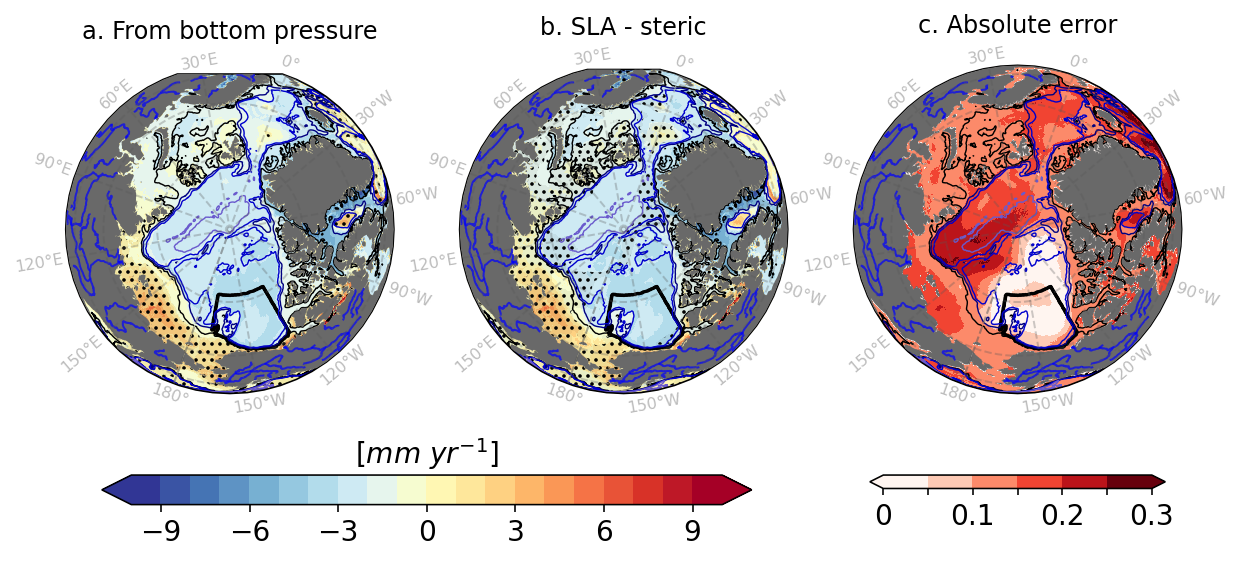

In [55]:
trdata  = ccrs.PlateCarree()
proj = ccrs.NearsidePerspective(central_longitude=loncentr, central_latitude=latcentr,satellite_height=sath)

rivers = cartopy.feature.NaturalEarthFeature(category='physical', name='rivers_lake_centerlines',scale='50m',facecolor='none',edgecolor='b')

label_style = {'size': 8, 'color': '#BDBDBD', 'weight': 'normal'}
bathy_levels = [200,1000,2000,4000] # We will apply a Gaussian filter to smooth the data. 
color_levels= ['k','navy','mediumblue','slateblue']

fig, [axa, axd, axg] = plt.subplots(1, 3, figsize=(10,30), facecolor='none', dpi=72*2, subplot_kw={'projection': proj})

#----------------- MANO from PB --------------------------------------
# ========GAI
data2plot = (man_Tr_GAI_PB).where(tmask!=0,0).squeeze()
axa.contour(nav_lon,nav_lat,BGRmask,1,colors="k",transform=trdata)
cs  = axa.pcolormesh(nav_lon, nav_lat, data2plot,shading='flat',cmap = mycm1,transform=trdata,norm=norm1)
# significance
cs2_2= axa.contourf(nav_lon, nav_lat, man_TrGAI_PB_signi.where(man_TrGAI_PB_signi==1).where(nav_lon>0),transform=trdata, \
                    colors='none',alpha=alphaHatch,hatches=['...'*1, '/'])
vectorize(cs2_2)

cs2_1= axa.contourf(nav_lon, nav_lat,man_TrGAI_PB_signi.where(man_TrGAI_PB_signi==1).where(nav_lon<0),transform=trdata, \
                  colors='none',alpha=alphaHatch,hatches=['...'*1, '/'])
vectorize(cs2_1)

clr2 = axa.add_feature(rivers,alpha=0.7,facecolor='none',edgecolor='blue',zorder=6)
cl2  = axa.add_feature(cfeature.LAND.with_scale('50m'),facecolor="dimgrey",edgecolor= 'none',alpha=1,zorder=5)
gl   = axa.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
gl.xlabel_style = label_style; gl.ylabel_style = label_style

Ct1 = axa.contour(nav_lon,nav_lat,mbathy.where(nav_lon<0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)
Ct2 = axa.contour(nav_lon,nav_lat,mbathy.where(nav_lon>0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)
axa.set_title("a. From bottom pressure", fontsize=12) 

#----------------- mano as a difference --------------------------------------
# ========GAI
data2plot = (manTrGAI_diff).where(tmask!=0,0).squeeze()
axd.contour(nav_lon,nav_lat,BGRmask,1,colors="k",transform=trdata)
cs  = axd.pcolormesh(nav_lon, nav_lat, data2plot,shading='flat',cmap = mycm1,transform=trdata,norm=norm1)
# significance
cs2_2= axd.contourf(nav_lon, nav_lat, sla_TrGAI_signi.where(sla_TrGAI_signi==1).where(nav_lon>0),transform=trdata, \
                    colors='none',alpha=alphaHatch,hatches=['...'*1, '/'])
vectorize(cs2_2)

cs2_1= axd.contourf(nav_lon, nav_lat,sla_TrGAI_signi.where(sla_TrGAI_signi==1).where(nav_lon<0),transform=trdata, \
                  colors='none',alpha=alphaHatch,hatches=['...'*1, '/'])
vectorize(cs2_1)

clr2 = axd.add_feature(rivers,alpha=0.7,facecolor='none',edgecolor='blue',zorder=6)
cl2  = axd.add_feature(cfeature.LAND.with_scale('50m'),facecolor="dimgrey",edgecolor= 'none',alpha=1,zorder=5)
gl   = axd.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
gl.xlabel_style = label_style; gl.ylabel_style = label_style

Ct1 = axd.contour(nav_lon,nav_lat,mbathy.where(nav_lon<0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)
Ct2 = axd.contour(nav_lon,nav_lat,mbathy.where(nav_lon>0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)
axd.set_title("b. SLA - steric", fontsize=12) 

cbar = fig.colorbar(cs, ax=[axa, axd], orientation='horizontal',extend='both', pad = 0.025,  shrink=0.9)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_title(r'[$mm$ $yr^{-1}$]',size=14)

#----------------- erreur absolue : Mano_Pb - Mano_inferred --------------------------------------
# ========GAI
data2plot = (DIFF).where(tmask!=0,0).squeeze()
axg.contour(nav_lon,nav_lat,BGRmask,1,colors="k",transform=trdata)
cs  = axg.pcolormesh(nav_lon, nav_lat, data2plot,shading='flat',cmap = mycm2,transform=trdata,norm=norm2)

clr2 = axg.add_feature(rivers,alpha=0.7,facecolor='none',edgecolor='blue',zorder=6)
cl2  = axg.add_feature(cfeature.LAND.with_scale('50m'),facecolor="dimgrey",edgecolor= 'none',alpha=1,zorder=5)
gl   = axg.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
gl.xlabel_style = label_style; gl.ylabel_style = label_style

Ct1 = axg.contour(nav_lon,nav_lat,mbathy.where(nav_lon<0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)
Ct2 = axg.contour(nav_lon,nav_lat,mbathy.where(nav_lon>0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)
axg.set_title("c. Absolute error", fontsize=12) 

cbar = fig.colorbar(cs, ax=axg, orientation='horizontal', extend='both',pad = 0.025, shrink=0.9)
cbar.set_ticks(bounds2)
cbar.set_ticklabels(['0','','0.1','','0.2','','0.3'])
cbar.ax.tick_params(labelsize=14)
# cbar.ax.set_title('[$10^{-1}$]',size=14)

# fig.subplots_adjust(bottom=0.18)
# cbar_ax = fig.add_axes([0.15, 0.14, 0.7, 0.02])  #(left, bottom, width, height)
# cbar = fig.colorbar(cs,extend='both', ticks=bounds, cax=cbar_ax, orientation='horizontal')
# cbar.ax.tick_params(labelsize=12)
# cbar.set_label(r'Trends over '+y1+'-'+y2+r' [$mm$ $yr^{-1}$]', fontsize=24)
# ## cbar = fig.colorbar(cs,extend='both', ticks=bounds, ax=[axm,axn,axo],  location='bottom') #, cax = axm.inset_axes([ 0,1.1, 1.0, 0.05]))  # [1.1, 0, 0.05, 1.0]

namo="maps_signi010_mano_pb_vs_diff_trends_4review.png"
# fig.tight_layout(pad=0, h_pad=5, w_pad=0)
plt.show()
# fig.savefig(diro+namo, facecolor=fig.get_facecolor(), bbox_inches='tight') #,edgecolor='none', 
# plt.close(fig)

In [ ]:
bounds

In [37]:
diff_mask = DIFF.where(BGRmask, drop=True)

In [38]:
e1t = mesh_hgr.e1t.fillna(0)
e2t = mesh_hgr.e2t.fillna(0)

# nav_lon =  mesh_hgr.nav_lon
# nav_lat =  mesh_hgr.nav_lat

bt = (e1t * e2t).load()# area of each cell

btboxBG = bt.where(BGRmask,drop=True)
tmaskboxBG = tmask.where(BGRmask,drop=True)
oceanAreaBG = (btboxBG*tmaskboxBG[0])  #tmask : 1 on ocean, 0 on land
totalOceanAreaBG = oceanAreaBG.sum()
WeightboxBG = (oceanAreaBG / totalOceanAreaBG) #.compute()

err_mask_mean = (diff_mask * WeightboxBG).sum(('x','y')).compute()


In [39]:
err_mask_mean
# 

<xarray.DataArray ()>
array(0.04151225)
Coordinates:
    parameter     <U5 'slope'
    time_counter  float64 0.0
    nav_lev       float32 0.5058

In [40]:
diff_mask.max()

<xarray.DataArray 'linregress' ()>
array(0.12373128)
Coordinates:
    parameter  <U5 'slope'

In [41]:
diff_mask.min()

<xarray.DataArray 'linregress' ()>
array(1.8655713e-06)
Coordinates:
    parameter  <U5 'slope'